In [2]:
using PlutoUI, Plots, Statistics, Optim, JuMP, Ipopt, ForwardDiff

## Optimization with Julia!!! 

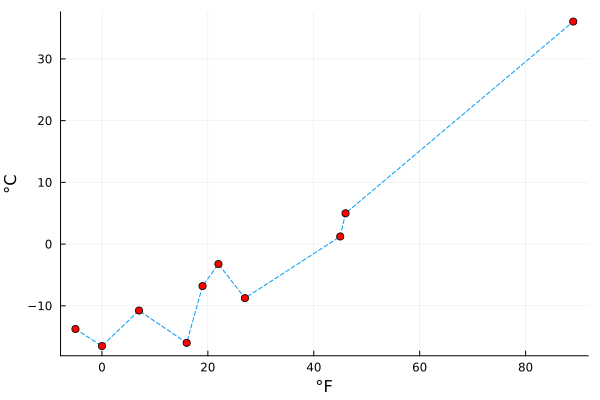

In [15]:
n = 10 ; 
x = sort( rand( -10:100, n ) )
y = 5/9 .* x .- 17.777 .+ 5 .* randn.()  #  same as y =  5/9 .* (x .- 32)

begin 
    plot(x,y, m=:c, mc=:red, legend=false, ls=:dash) 
    xlabel!("°F")
    ylabel!("°C")
end 

## Least Squares Fitting 

Given data $x_i$ and measurements $y_i$, *least squares fitting* finds the best slope, $m$, and intercept, $b$, that minimizes the square of the error:

\begin{equation*}
    \operatorname*{argmin}_{m, b} \sum \Big( ( b + mx_i ) - y_i \Big)^2 
\end{equation*}


In [37]:
# The Statistician's Formula 

begin 

    m = cov(x,y) / var(x) 
    m_ls = (x .- mean(x)) \ (y .- mean(y)) 
    b = mean(y) - m_ls * mean(x)  

end 

println("y = (", m, ") x + (", b, ")" )
println("y = (", m_ls, ") x + (", b, ")" )

y = (0.5350616218522564) x + (-17.587082279528833)
y = (0.5350616218522564) x + (-17.587082279528833)


In [36]:
# The Linear Algebraist's Formula 

line = [one.(x) x]\y
b = line[1]  
m = line[2] 

println("y = (", m, ") x + (", b, ")" )


y = (0.535061621852256) x + (-17.58708227952882)


## Optimization Methods 

Least squares is actually an optimization problem - rather than using linear algebra, use optimization algorithms (overkill for lines) to find solution! 

### Optim.jl: Julia's optimization package 

Link to documentation: https://julianlsolvers.github.io/Optim.jl/stable/# 

Use `Optim.jl` to solve: 

\begin{equation*}
    \operatorname*{argmin}_{m, b} \sum_{i=1}^{n} \Big[ ( b + mx_i ) - y_i \Big]^2 
\end{equation*}

as: 

\begin{equation*}
    \operatorname*{argmin}_{m, b} loss(b,m) 
\end{equation*}

In [45]:
# loss function 
loss( (b,m) ) = sum( ( b + m*x[i] - y[i] )^2 for i = 1:n )

result = optimize( loss, [0.0, 0.0] )
println(result) 


 * Status: success

 * Candidate solution
    Final objective value:     2.081839e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    62
    f(x) calls:    119



In [46]:
display(result.minimizer) 

2-element Vector{Float64}:
 -17.58709174165527
   0.5350614977610846

### `JuMP.jl`: A popular modelling language for Optimization Problems 

JuMP = Julia for Mathematical Programming 

In [52]:
let 

    n = length(x) 
    model = Model(Ipopt.Optimizer) 

    @variable(model, b) 
    @variable(model, m) 

    # must write out objective function again ... can't input loss 
    @objective( model, Min, sum( ( b + m*x[i] - y[i] )^2 for i = 1:n ) )

    # set_silent(model) 
    optimize!(model) 

    ( b = value(b), v = value(m) )

end 

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2933659e+03 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

(b = -17.587082279528826, v = 0.5350616218522563)

## Gradients 

Here are 3 ways to compute gradients: 
1. Hand computation 
2. Finite differencing 
3. Autodifferentiation 

### Hand computation 

Differentiate with respect to $b$: 
\begin{equation*}
    \frac{\partial}{\partial b} \sum_{i=1} ^{n} \Big[ ( b + mx_i ) - y_i \Big]^2 
    = 
    2 \sum_{i=1}^{n} \Big[ ( b + mx_i ) - y_i \Big] 
\end{equation*}

Differentiate with respect to $m$: 
\begin{equation*}
    \frac{\partial}{\partial m} \sum_{i=1} ^{n} \Big[ ( b + mx_i ) - y_i \Big]^2 
    = 
    2 \sum_{i=1}^{n} \Big[ ( b + mx_i ) - y_i \Big] x_i 
\end{equation*}

In [64]:
begin

    #i-th summand 
    ∇loss(b,m,i) = 2 * ( b + m*x[i] - y[i] ) .* [1, x[i]]  
    ∇loss(b,m) = sum(∇loss(b,m,i) for i = 1:n)

end 

b_loss = 0.1 ; 
m_loss = 0.3 ; 
∇loss(b_loss, m_loss) 

2-element Vector{Float64}:
  228.68886276517625
 2843.7865511321124

### Finite Difference 

In [70]:
begin 

    ϵ = .000000001; 
    db = ( loss( [b_loss + ϵ, m_loss] ) - loss([b_loss, m_loss])) / ϵ ; 
    dm = ( loss( [b_loss, m_loss + ϵ] ) - loss([b_loss, m_loss])) / ϵ ; 
    dbdm = [db; dm]

end 

2-element Vector{Float64}:
  228.68971427669746
 2843.786887751776

In [73]:
# shorter way in Julia: 
begin # finite difference
	ϵ = .000000001
	( [loss([b_loss + ϵ , m_loss]);
       loss([b_loss , m_loss + ϵ])] .- loss([b_loss , m_loss]) ) ./ ϵ
end

2-element Vector{Float64}:
  228.68971427669746
 2843.786887751776

### Automatic Differentiation (AutoDiff) 

LET THE COMPUTER DO IT 

In [78]:
hand_g = ∇loss(b_loss, m_loss) 
println("Hand Gradient = ", hand_g)

auto_g = ForwardDiff.gradient( loss, [b_loss, m_loss] ) 
println("AutoDiff gradient = ", auto_g)


Hand Gradient = [228.68886276517625, 2843.7865511321124]
AutoDiff gradient = [228.68886276517625, 2843.7865511321124]


Observe some options for `optimize`: 

In [85]:
# optimize with starting guess [0.0, 0.0]
result = optimize(loss, [0.0,0.0], BFGS(),  autodiff=:forward)
display(result) 

println("Minimizer = ", result.minimizer) 

 * Status: success

 * Candidate solution
    Final objective value:     2.081839e+02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.76e+01 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.00e+00 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.53e+03 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.33e+00 ≰ 0.0e+00
    |g(x)|                 = 1.82e-12 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    5
    ∇f(x) calls:   5


Minimizer = [-17.58708227952883, 0.5350616218522563]


In [86]:
optimize( loss, [0.0, 0.0], BFGS() )


 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     2.081839e+02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.84e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.05e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.84e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.37e-16 ≰ 0.0e+00
    |g(x)|                 = 4.69e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    3
    f(x) calls:    8
    ∇f(x) calls:   8


In [87]:
optimize( loss, [0.0, 0.0], GradientDescent() )


 * Status: success

 * Candidate solution
    Final objective value:     2.081839e+02

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 1.64e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.35e-12 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 8.75e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    133
    f(x) calls:    595
    ∇f(x) calls:   595
